5bi: theta= [[  2.51339906e+00]
 [ -9.81122145e-04]]
Training set error: 1.06639580238
Test set error: 2.7099695794


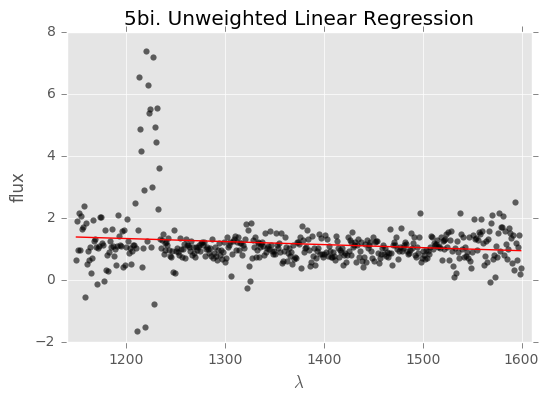

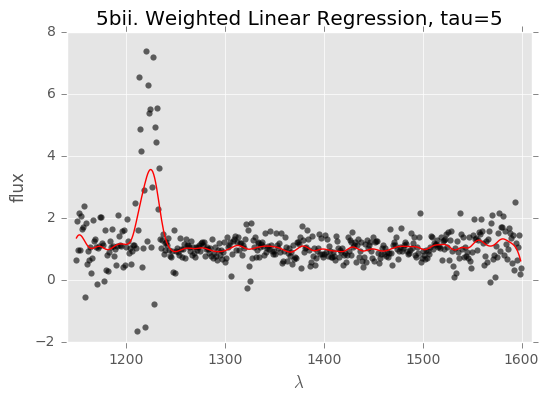

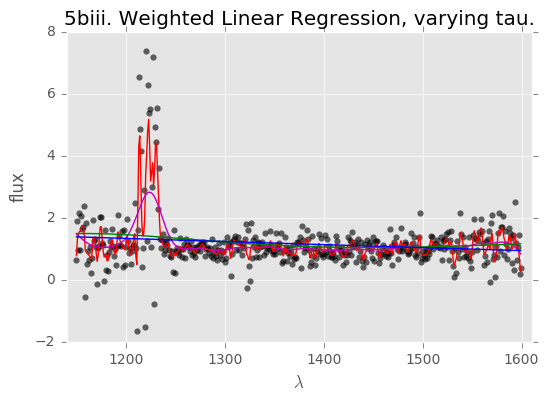

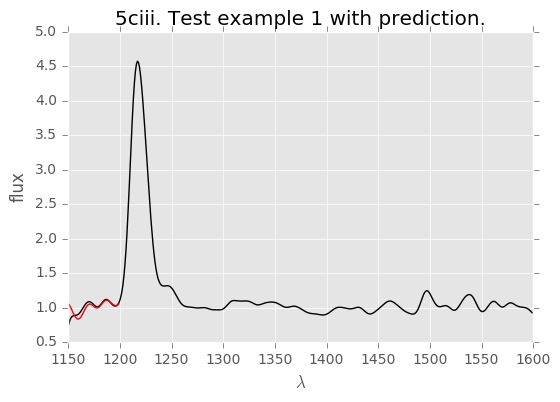

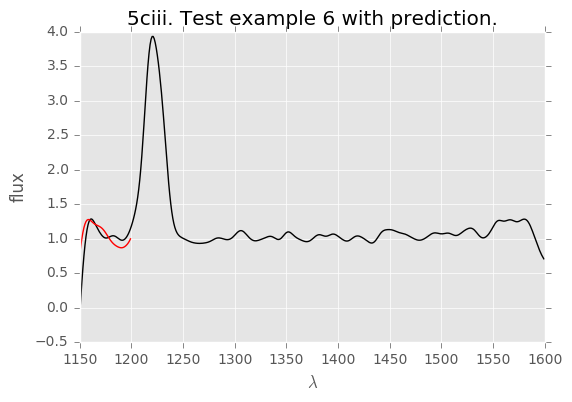

In [33]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

def main():
    train_df = pd.read_csv('data/quasar_train.csv', header = 0)
    test_df = pd.read_csv('data/quasar_test.csv', header = 0)
    
    wavelength= np.array(train_df.columns, dtype=float, ndmin=2)
    flux = np.transpose(np.array(train_df[0:1]))
    
    #unweighted linear regression (5bi.)
    theta = linreg(wavelength, flux)
    print('5bi: theta= ' + str(theta))
    line = np.add(theta[0], np.multiply(theta[1], wavelength))
    
    #unweighted linear regression plot (5bi.)
    plt.scatter(x=wavelength, y=flux, c='black', alpha=0.6, linewidths=0)
    plt.plot(wavelength[0], line[0], 'r-')
    plt.axis([1140,1610,-2,8])
    plt.xlabel('$\lambda$')
    plt.ylabel('flux')
    plt.title('5bi. Unweighted Linear Regression')
    plt.savefig('ps1-5bi.png')
    
    #weighted linear regression (5bii.)
    theta_weighted = weighted_linreg(wavelength, flux, tau=5)
    line_weighted = np.add(theta_weighted[:,0] , np.multiply(theta_weighted[:,1], wavelength))
    
    #weighted linear regression (5bii.)
    plt.figure()
    plt.scatter(x=wavelength, y=flux, c='black', alpha=0.6, linewidths=0)
    plt.plot(wavelength[0], line_weighted[0], 'r-')
    plt.axis([1140,1610,-2,8])
    plt.xlabel('$\lambda$')
    plt.ylabel('flux')
    plt.title('5bii. Weighted Linear Regression, tau=5')
    plt.savefig('ps1-5bii.png')
    
    #weighted linear regression (5biii.)
    plt.figure()
    plt.scatter(x=wavelength, y=flux, c='black', alpha=0.6, linewidths=0)
    plt.axis([1140,1610,-2,8])
    plt.xlabel('$\lambda$')
    plt.ylabel('flux')
    plt.title('5biii. Weighted Linear Regression, varying tau.')
    colors = ['r-', 'm-', 'g-', 'b-']
    tvalues = np.array([1, 10, 100, 1000])
    for i in range(0, tvalues.shape[0]):
        theta_new = weighted_linreg(wavelength, flux, tau=tvalues[i])
        line_new = np.add(theta_new[:,0] , np.multiply(theta_new[:,1], wavelength))
        plt.plot(wavelength[0], line_new[0], colors[i])
    plt.savefig('ps1-5biii.png')
    
    #smooth data with tau=5 (5ci.)
    #smooth(train_df, test_df) #uncomment to re-run smoothing function
    train_smooth = np.loadtxt('data/quasar_train_smooth.csv', delimiter=',')
    test_smooth = np.loadtxt('data/quasar_test_smooth.csv', delimiter=',')
    
    #functional regression on training data (5cii.)
    train_pred = fpred(train=train_smooth, test=train_smooth,n=3)
    train_err = get_error(train_smooth, train_pred)
    print("Training set error: "+ str(train_err))
    
    #functional regression on test data (5ciii.)
    test_pred = fpred(train=train_smooth, test=test_smooth, n=3)
    test_err = get_error(test_smooth, test_pred)
    print("Test set error: "+ str(test_err))
    
    #plot test example 1 (5ciii.)
    plt.figure()
    plt.plot(wavelength[0], test_smooth[0], 'k-')
    plt.plot(wavelength[0,0:50], test_pred[0], 'r-')
    plt.xlabel('$\lambda$')
    plt.ylabel('flux')
    plt.title('5ciii. Test example 1 with prediction.')
    plt.savefig('ps1-5ciii-1.png')
    
    #plot test example 6 (5ciii.)
    plt.figure()
    plt.plot(wavelength[0], test_smooth[5], 'k-')
    plt.plot(wavelength[0,0:50], test_pred[5], 'r-')
    plt.xlabel('$\lambda$')
    plt.ylabel('flux')
    plt.title('5ciii. Test example 6 with prediction.')
    plt.savefig('ps1-5ciii-2.png')
             
def get_error(truth, prediction):
    m = truth.shape[0]
    error = np.zeros((m,1))
    for i in range(0,m):
        error[i] = left_dist(truth[i], prediction[i])
    return np.divide(np.sum(error), m)

def fpred(train, test, n=3):
    m_train = train.shape[0] # training examples
    m_test = test.shape[0]
    
    predictions = np.zeros((m_test, 50))
    
    for f in range(0, m_test): #for each test example
        distances = np.zeros((m_train,1)) 
        for i in range(0, m_train): #for each training example
            distances[i] = right_dist(test[f],train[i])
        h = np.max(distances)
        indices = np.argsort(distances, axis=0)[0:n] #for train set, the nearest neighbor will include the training example itself (d=0)
                    
        fweights = np.zeros((n,1))
        for i in range(0,n):
            fweights[i] = ker(np.divide(distances[indices[i]],h))
        den = sum(fweights)
        for w in range(0,50):
            num = np.sum(np.multiply(fweights, train[indices, w]))
            predictions[f,w] = np.divide(num,den)
    return predictions
        
def linreg(x,y):
    x = np.transpose(np.vstack((np.ones_like(x), x)))
    return (np.dot(
                np.linalg.inv(np.dot(np.transpose(x)
                                    ,x)
                ),
                np.dot(np.transpose(x), y)
                )
           )

def weighted_linreg(x,y,tau):
    x = np.transpose(np.vstack((np.ones_like(x), x)))
    theta = np.zeros((x.shape[0],2))
    counter = 0
    for query in x[:,1]:
        weight = (np.diag(
                    np.exp(
                        np.divide(
                            np.power(np.subtract(query,x[:,1]),
                                     2),
                            np.multiply(np.negative(2),
                                        np.power(tau,2)
                                        )
                                )
                            )
                        )
                 )
        theta[counter] =  np.reshape(np.dot(
                                np.dot(
                                    np.dot(
                                        np.linalg.inv(
                                            np.dot(
                                                np.dot(
                                                    np.transpose(x), weight),
                                                    x
                                                    )
                                            ),
                                        np.transpose(x)
                                        ),
                                    weight),
                                y
                                )
                             ,(2,))
        counter = counter + 1
    return theta

def smooth(train_df, test_df):
    train_smooth = np.zeros_like(train_df)
    test_smooth = np.zeros_like(test_df)
    
    for i in range(0, train_smooth.shape[0]):
        theta_smooth = weighted_linreg(wavelength, np.transpose(np.array(train_df[i:i+1])), tau=5)
        train_smooth[i] = np.add(theta_smooth[:,0] , np.multiply(theta_smooth[:,1], wavelength))
    for j in range(0, test_smooth.shape[0]):
        theta_smooth = weighted_linreg(wavelength, np.transpose(np.array(test_df[j:j+1])), tau=5)
        test_smooth[j] = np.add(theta_smooth[:,0] , np.multiply(theta_smooth[:,1], wavelength))
        
    np.savetxt('data/quasar_train_smooth.csv', train_smooth, delimiter=',')
    np.savetxt('data/quasar_test_smooth.csv', test_smooth, delimiter=',')

def right_dist(f1, f2):
    f1right = f1[150:450]
    f2right = f2[150:450]
    return np.sum(np.power(np.subtract(f1right,f2right),2))

def left_dist(f1, f2):
    f1left = f1[0:50]
    f2left = f2[0:50]
    return np.sum(np.power(np.subtract(f1left,f2left),2))

def ker(x):
    return np.max([1-x, 0])
    
if __name__ == "__main__":
    main()
    